# Load Xephyr

As usual first we need to load the Xephyr libraries and any other shared libraries we may want use

In [1]:
gROOT->ProcessLine(".x ../loadXephyr.C");



      =================== Welcome to Xephyr =====================
       Version 6.0 dated 10-Oct-2017, compiled with ROOT 6.14/00

(int) 0


Check that Xephyr was compiled with the ROOT version you are currently running. If not you need to make sure jupyter is running the right kernel. 

In [2]:
cout<<"Kernel version:  "<<gROOT->GetVersion();

Kernel version:  6.14/00

Great, now we can get to work!
# Set up the profile likelihood
For a more detailed example of setting up the likelihood see the likelihood_setup_example notebook.

#### Create one or more background components

Create a pdfComponent Object as follows:
``` cpp
    pdfComponent *comp = new pdfComponent(TString component_name, TString histogram_name, TString root_file_path);
```


The histogram name Xephyr will look for in the file will be the given name then each shape systematic followed by their values in the following format:
```bash
<hist_name><shape_sys_1_name><shape_sys_1_value><shape_sys_2_name><shape_sys_2_value>...<shape_sys_N_name><shape_sys_N_value>[<optional_suffix>].root
```

You can add an optional suffix by executing the following line:
``` cpp
    pdf_component->suffix = "<suffix>";
```

The ER backgorund file we will use for this example contains model histograms with the following naming format:
``` bash
    hbkg_py0_<py0_value>_rf0_<rf0_value>
```

First, when creating the pdfComponent, we pass the prefix common to all histogram names as the histogram_name parameter. In this case "hbkg"

In [3]:
pdfComponent *ER = new pdfComponent("ER", "hbkg", "./data_examples/ERBackgroundModel_SR1_From_Combined180104Fit.root");

pdfComponent::Constructor - INFO : Reading file ./data_examples/ERBackgroundModel_SR1_From_Combined180104Fit.root


Add a scale systematic by creating a new scaleSys object:
```cpp
    scaleSys *scale_sys = new scaleSys(TString name, float value);
```
and set the minimum and maximum values it can take:
```cpp
    scale_sys->setMinimum(-0.5);
    scale_sys->setMaximum(0.5);
```
as well as its type:
```cpp
    scale_sys->setType(FREE_PARAMETER);
```
the type can be one of the following
```bash
    PARAMETER_OF_INTEREST , NUISANCE_PARAMETER , FIXED_PARAMETER , FROZEN_PARAMETER
```

finally you can set the value of any parameter by just calling:
```cpp
parameter_pointer->setCurrentValue( double some_value)
```


In [4]:
scaleSys *s1 = new scaleSys("ERscale",1.);
s1->setMinimum(-0.5);
s1->setMaximum(0.5);
s1->setType(FREE_PARAMETER);

Then add the scale systematic to the model using the addScaleSys method.
```cpp
    pdf_component->addScaleSys(scaleSys scale_sys);
```

In [5]:
ER->addScaleSys(s1);

Add shape uncertainty parameters by creating a shapeSys object for each uncertainty as follows:
```cpp
    shapeSys *shape_sys = new shapeSys(TString parameter_name);
```
<span style="color:red;font-weight:bold">IMPORTANT</span>   parameter_name must match the name used in the histogram keys in the file being used.


Then set the minimum, maximum and step between values the file has histograms for:
```cpp
    shape_sys->setMinimum(float parameter_min);
    shape_sys->setMaximum(float parameter_max);
    shape_sys->setStep(float parameter_step);  
```

In [6]:
shapeSys *PY = new shapeSys("_py0_");
PY->setStep(1.);        
PY->setMinimum(-1.);
PY->setMaximum(1.);
PY->setType(FREE_PARAMETER);

shapeSys *RF = new shapeSys("_rf0_");
RF->setStep(1.);                     
RF->setMinimum(-2.);
RF->setMaximum(2.);
RF->setType(FREE_PARAMETER);


And finally add the uncertainties in the order their parameter appears in the histogram names using the addShapeSys method:
```cpp
    pdf_component->addShapeSys(shape_sys);
```

In [7]:
ER->addShapeSys(PY);
ER->addShapeSys(RF);

In [8]:
ER->setEvents(60);  // my best guess for ER events, this will scale the histo to that number of events, no matter what.

#### Add the signal component

The signal file we will use for this example has no shape uncertainty.

In [9]:
pdfComponent *Signal = new pdfComponent( "SIGNAL" , "signal_rescaled", "../examples/SR1Like/data/SignalModel_SR1_50GeV_FromRunSourceCombinedFit180420.root");

pdfComponent::Constructor - INFO : Reading file ../examples/SR1Like/data/SignalModel_SR1_50GeV_FromRunSourceCombinedFit180420.root


In [10]:
// this is a method that allows you to scale any pdfComponent to an arbitrary exposure (here set to dummy 1)
// Remember: the histograms are in number of events
Signal->setScaleFactor(1.);  

In [11]:
scaleSys *s2 = new scaleSys("SignalScale", 0.3);  // 30% relative scale uncertainty on signal
Signal->addScaleSys(s2);


#### Add the data:

In [12]:
dataHandler *data = new dataHandler("data_sr0","./data_examples/xephyr_data_none_lowenergy_roi.root", "DMtree");

// Note: in this example we compare SR0 data to SR1 models (just because), that's why the fit might be horrific, 
// don't do it at home ;)

Now we can set up a likelihood object as follows:

   ```cpp
    pdfLikelihood *pl = new pdfLikelihood(TString likelihood_Name, double  wimp_mass);
```


In [13]:
pdfLikelihood *pl = new pdfLikelihood("simple_pl", 100);

Then add the pdf components we created (signal and background) to it

In [14]:
pl->setExperiment(1);  // Set the experiment number (useful in case you want to combine multiple experiments)

pl->addBkgPdfComponent(ER, true); // Add the background components, 
                                  // the argument true or false mean if this bkg is considered in the safeguard fit or not

// pl->addBkgPdfComponent(Another component, false); // you can add as many component background component you like

pl->setSignalPdf(Signal); // Add a signal component

pl->setDataHandler(data); // Add the data handler we created.

pl->setSignalDefaultNorm(1.E-45); // Set the cross section normalization that corresponds to the default signal model.

pl->setWithSafeGuard(false); // Enable/Disable safeguard


pdfLikelihood - INFO: bkg component named ER added to    SAFEGUARDED


And finally, before we start to work with the likelihood we need to initialzie it.

In [15]:
pl->initialize()

pdfLikelihood::initialize - INFO :  initialize..... 
	Likelihood::addParameter - Info : Adding parameter Sigma  with ID -1  to PL simple_pl
INFO :  adding sys for BKG component ER
	Likelihood::addParameter - Info : Adding parameter ERscale  with ID 1  to PL simple_pl
	Likelihood::addParameter - Info : Adding parameter _py0_  with ID 2  to PL simple_pl
	Likelihood::addParameter - Info : Adding parameter _rf0_  with ID 3  to PL simple_pl
INFO :  adding sys for SIGNAL component SIGNAL
	Likelihood::addParameter - Info : Adding parameter SignalScale  with ID 4  to PL simple_pl

------ WARNING -------  Safeguard is turned OFF altough you have set components to be safeguarded this is ignored -----

pdfLikelihood::initialize - INFO :  initialization SUCCESSFUL. 


<span style="color:red;font-weight:bold">IMPORTANT</span>  
Always initialize the likelihood before use. Go over the output and check that no errors occured and models were defined correctly and all model histograms were found.

It is also useful at this point to print the event summary and check that the data has been imported correctly.

In [16]:
pl->printEventSummary();



--------------Event Summary------------------
PdfComponent Name 	Events
ER 	 60.0000
Signal 	 171.5379
dataHandler:: summary:  name= data_sr1,  N=63 


# Maximize the likelihood
This will scan the parameter $\mu$ to find the one that maximizes the likelihood, for each value of $\mu$ all the uncertainty variables are simultaneously fit.

```cpp
// the boolean argument tells if you want to make the fit with mu fixed to some predefined values
pl->maximize( bool fixPOI)   
```

In [17]:
pl->printCurrentParameters();

 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 ERscale              Free               0                 
  2 _py0_                Free               0                 
  3 _rf0_                Free               0                 
  4 SignalScale          Nuisance           0                 


In [18]:
pl->maximize(false)

Finding maximum of simple_pl
Total of 5 active parameters, don't freeze parameters of interest, Minuit fits 5 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 ERscale              Free               0                 
  2 _py0_                Free               0                 
  3 _rf0_                Free               0                 
  4 SignalScale          Nuisance           0                 
ML -268.608 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      1.3 +- 2.2      
  1 ERscale              Free           0.029 +- 0.18     
  2 _py0_                Free              -1 +- 0.43     
  3 _rf0_                Free         0.00021 +- 0.06     
  4 SignalScale          Nuisance      -4e-05 +- 1.4      
(double) -268.60844


In [19]:
pl->printCurrentParameters(); 

 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      1.3                 
  1 ERscale              Free           0.029                 
  2 _py0_                Free              -1                 
  3 _rf0_                Free         0.00021                 
  4 SignalScale          Nuisance      -4e-05                 


You may notice that Sigma (the POI) has best fit at 3, now, no matter how you scale the histogram or rescale the signal PDF, the POI is always in absolute number of signal events (Xephyr re-scales it for you and keep track of the scale).
So this means 3 signal events! Well, here we didn't have any other background than ER.

What we did above is called unconditional fit, meaning we find the global maximum. To compute the test statistic one need also anothe ingredient which is the **conditional fit**, basically finding the local maxima of all parameter fixing the parameter of interest to some value. Let's do it:


In [20]:
// Get a pointer to the parameter of interest (POI) and change its value 
pl->getPOI()->setCurrentValue(5.);

// fit again, this time with conditional fit
pl->maximize(true);   // notice is true now !!!

// Also note below how the SignalScale paramter now assumes a negative value, 
// trying to compensate for the fixed large signal

Finding maximum of simple_pl
Total of 5 active parameters,  freeze parameters of interest, Minuit fits 4 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             5                 
  1 ERscale              Free           0.029                 
  2 _py0_                Free              -1                 
  3 _rf0_                Free         0.00021                 
  4 SignalScale          Nuisance      -4e-05                 
ML -269.704 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             5                 
  1 ERscale              Free           0.017 +- 0.18     
  2 _py0_                Free              -1 +- 0.37     
  3 _rf0_                Free            0.33 +- 2.5      
  4 SignalScale          Nuisance       -0.74 +- 1.3      


# Draw the likelihood curve
The likelihood curve contain much information and it is highly recomended to plot it when doing sanity checks on results. Use the getGraphOfLogLikelihood method to calculate the likelihood on a span of cross sections:

```cpp
    TGraph *tgraph = profileLikelihood->getGraphOfLogLikelihood(int number_of_points);
```

<span style="color:orange;font-weight:bold">WARNING</span>   This can take some time to calculate.


In [21]:
pl->getPOI()->setMinimum(0.);

In [22]:
pl->getPOI()->setMaximum(15.);

In [23]:
TGraph *pl_graph = pl->getGraphOfLogLikelihood(50);

Finding maximum of simple_pl
Total of 5 active parameters, don't freeze parameters of interest, Minuit fits 5 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        5                 
  1 ERscale              Free           0.017                 
  2 _py0_                Free              -1                 
  3 _rf0_                Free            0.33                 
  4 SignalScale          Nuisance       -0.74                 
ML -268.608 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      1.3 +- 2.1      
  1 ERscale              Free           0.029 +- 0.18     
  2 _py0_                Free              -1 +- 0.44     
  3 _rf0_                Free         0.00016 +- 0.055    
  4 SignalScale          Nuisance    -3.9e-06 +- 1.4      
min:  0   Max:  15   PostFit:   1.28564  LL max -268.608
min:  0   Max:  15   PostFit:   1.

ML -268.617 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.5                 
  1 ERscale              Free           0.027 +- 0.18     
  2 _py0_                Free              -1 +- 0.42     
  3 _rf0_                Free         0.00028 +- 0.072    
  4 SignalScale          Nuisance      -0.036 +- 1.3      
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.5                 
  1 ERscale              Free           0.027                 
  2 _py0_                Free              -1                 
  3 _rf0_                Free         0.00028                 
  4 SignalScale          Nuisance      -0.036                 
min:  0   Max:  15   PostFit:   1.28564  LL max -268.608
Finding maximum of simple_pl
Total of 5 active parameters,  freeze parameters of interest, Minuit fits 4 param.
 Id Name                 Type      

ML -269.176 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.6                 
  1 ERscale              Free            0.02 +- 0.18     
  2 _py0_                Free              -1 +- 0.38     
  3 _rf0_                Free            0.23 +- 2.4      
  4 SignalScale          Nuisance       -0.45 +- 1.3      
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.6                 
  1 ERscale              Free            0.02                 
  2 _py0_                Free              -1                 
  3 _rf0_                Free            0.23                 
  4 SignalScale          Nuisance       -0.45                 
min:  0   Max:  15   PostFit:   1.28564  LL max -268.608
Finding maximum of simple_pl
Total of 5 active parameters,  freeze parameters of interest, Minuit fits 4 param.
 Id Name                 Type      

ML -269.972 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           5.7                 
  1 ERscale              Free           0.016 +- 0.18     
  2 _py0_                Free              -1 +- 0.36     
  3 _rf0_                Free            0.36 +- 2.5      
  4 SignalScale          Nuisance       -0.88 +- 1.3      
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           5.7                 
  1 ERscale              Free           0.016                 
  2 _py0_                Free              -1                 
  3 _rf0_                Free            0.36                 
  4 SignalScale          Nuisance       -0.88                 
min:  0   Max:  15   PostFit:   1.28564  LL max -268.608
Finding maximum of simple_pl
Total of 5 active parameters,  freeze parameters of interest, Minuit fits 4 param.
 Id Name                 Type      

ML -270.731 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           7.8                 
  1 ERscale              Free           0.015 +- 0.18     
  2 _py0_                Free              -1 +- 0.35     
  3 _rf0_                Free             0.4 +- 2.5      
  4 SignalScale          Nuisance        -1.3 +- 1.2      
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           7.8                 
  1 ERscale              Free           0.015                 
  2 _py0_                Free              -1                 
  3 _rf0_                Free             0.4                 
  4 SignalScale          Nuisance        -1.3                 
min:  0   Max:  15   PostFit:   1.28564  LL max -268.608
Finding maximum of simple_pl
Total of 5 active parameters,  freeze parameters of interest, Minuit fits 4 param.
 Id Name                 Type      

ML -271.383 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           9.9                 
  1 ERscale              Free           0.014 +- 0.18     
  2 _py0_                Free              -1 +- 0.36     
  3 _rf0_                Free            0.41 +- 2.5      
  4 SignalScale          Nuisance        -1.7 +- 1.1      
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           9.9                 
  1 ERscale              Free           0.014                 
  2 _py0_                Free              -1                 
  3 _rf0_                Free            0.41                 
  4 SignalScale          Nuisance        -1.7                 
min:  0   Max:  15   PostFit:   1.28564  LL max -268.608
Finding maximum of simple_pl
Total of 5 active parameters,  freeze parameters of interest, Minuit fits 4 param.
 Id Name                 Type      

ML -271.91 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen            12                 
  1 ERscale              Free           0.015 +- 0.18     
  2 _py0_                Free              -1 +- 0.35     
  3 _rf0_                Free             0.4 +- 2.5      
  4 SignalScale          Nuisance          -2 +- 1.1      
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen            12                 
  1 ERscale              Free           0.015                 
  2 _py0_                Free              -1                 
  3 _rf0_                Free             0.4                 
  4 SignalScale          Nuisance          -2                 
min:  0   Max:  15   PostFit:   1.28564  LL max -268.608
Finding maximum of simple_pl
Total of 5 active parameters,  freeze parameters of interest, Minuit fits 4 param.
 Id Name                 Type       

ML -272.321 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen            14                 
  1 ERscale              Free           0.015 +- 0.18     
  2 _py0_                Free              -1 +- 0.36     
  3 _rf0_                Free            0.38 +- 2.5      
  4 SignalScale          Nuisance        -2.3 +- 0.95     
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen            14                 
  1 ERscale              Free           0.015                 
  2 _py0_                Free              -1                 
  3 _rf0_                Free            0.38                 
  4 SignalScale          Nuisance        -2.3                 
min:  0   Max:  15   PostFit:   1.28564  LL max -268.608
Finding maximum of simple_pl
Total of 5 active parameters,  freeze parameters of interest, Minuit fits 4 param.
 Id Name                 Type      

In [24]:
TCanvas *pl_canvas = new TCanvas();

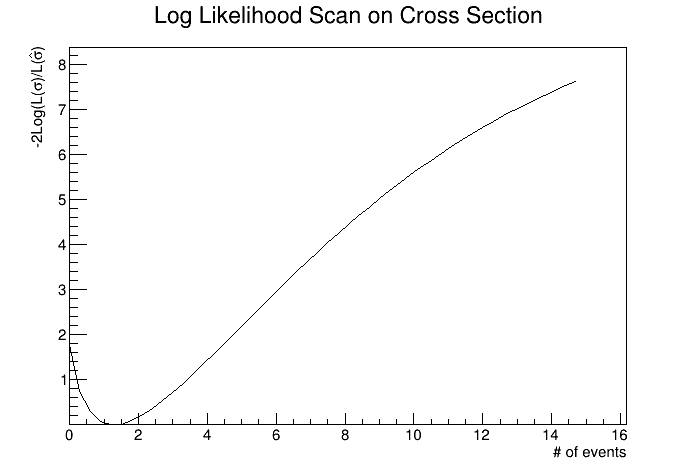

In [25]:
pl_graph->Draw();
pl_canvas->Draw();

# Set asymptotic limits
Given a required confidence level $\alpha$, it is possible to construct an estimator that will be larger than the parameter of interest in $1-\alpha$ fraction of similar experiments. Using asymptotic formulae this is easy since the distribution of the test statistic is known. The class offers all the tools needed for setting such a limit for any confidence level. To set limits we will create a new object of this class and pass our likelihood and confidence level to its constructor.
```cpp
    asym_exclusion = new AsymptoticExclusion(ProfileLikelihood likelihood, float alpha);
```


In [26]:
as = new AsymptoticExclusion(pl, 0.1);   // 0.1  --> means 90% CLs
  

Next we can set the number of points to scan when computing the limit and the min/max value of $\mu$ to test.

In [27]:
as->setNscanPoints(100);   // set the number of scan points for limit computation, the pvalues are computed in steps of the parameter of interest untill the CL is reached.
as->setScanMax(30.);    // Set the range of the scan (default 3 sigma from expected sensitivity)
as->setScanMin(0.);      // Set the range of the scan (default 0.) 

It is also possible to use the alternative test statistic $\tilde{q}$ defined in Eilams paper [here](https://arxiv.org/abs/1007.1727)

In [28]:
as->setQTilde(true);

Next we compute the sensitivity. This calculates the values of interest at the mean of the likelihood ratio.

In [29]:
as->computeSensitivity();

recomputing.... mu_hat
Finding maximum of simple_pl
Total of 5 active parameters, don't freeze parameters of interest, Minuit fits 5 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest       15                 
  1 ERscale              Free           0.016                 
  2 _py0_                Free              -1                 
  3 _rf0_                Free            0.38                 
  4 SignalScale          Nuisance        -2.3                 


Error in <TBranch::TBranch::WriteBasketImpl>: basket's WriteBuffer failed.

Error in <TBranch::TBranch::Fill>: Failed to write out basket.

Error in <TTree::Fill>: Failed filling branch:ASIMOV_DATA_0.00.cs1, nbytes=-1, entry=3989
 This error is symptomatic of a Tree created as a memory-resident Tree
 Instead of doing:
    TTree *T = new TTree(...)
    TFile *f = new TFile(...)
 you should do:
    TFile *f = new TFile(...)
    TTree *T = new TTree(...)


Error in <TBranch::TBranch::WriteBasketImpl>: basket's WriteBuffer failed.

Error in <TBranch::TBranch::Fill>: Failed to write out basket.

Error in <TTree::Fill>: Failed filling branch:ASIMOV_DATA_0.00.cs2, nbytes=-1, entry=3989
 This error is symptomatic of a Tree created as a memory-resident Tree
 Instead of doing:
    TTree *T = new TTree(...)
    TFile *f = new TFile(...)
 you should do:
    TFile *f = new TFile(...)
    TTree *T = new TTree(...)


Error in <TBranch::TBranch::WriteBasketImpl>: basket's WriteBuffer failed.

Error in

ML -246.942 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest  3.7e-05 +- 15       
  1 ERscale              Free           2e-05 +- 0.18     
  2 _py0_                Free         0.00014 +- 0.66     
  3 _rf0_                Free         0.00062 +- 2.5      
  4 SignalScale          Nuisance     2.7e-05 +- 1.4      
sigma min = 3.6866e-05
sigma min = 3.6866e-05
Finding maximum of simple_pl
Total of 5 active parameters,  freeze parameters of interest, Minuit fits 4 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen             1                 
  1 ERscale              Free               0                 
  2 _py0_                Free               0                 
  3 _rf0_                Free               0                 
  4 SignalScale          Nuisance           0                 
ML -247.329 achieved for 
 Id Name                

ML -247.707 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.8                 
  1 ERscale              Free          -0.011 +- 0.18     
  2 _py0_                Free          -0.079 +- 0.69     
  3 _rf0_                Free           -0.54 +- 2.3      
  4 SignalScale          Nuisance        -0.3 +- 1.4      
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           1.8                 
  1 ERscale              Free          -0.011                 
  2 _py0_                Free          -0.079                 
  3 _rf0_                Free           -0.54                 
  4 SignalScale          Nuisance        -0.3                 
 	  at: 1.750037 (min 0.000037)  q_lim=1.642374  ll0=-247.707405  qval=1.530844 diff=-0.111531 next-step=0.062500 
Finding maximum of simple_pl
Total of 5 active parameters,  freeze parameters of interest

Finally we calculate limits. This will calculate values of interest at the percentile you selected when creating the AsymptoticExclusion object for the likelihood.

In [30]:
as->computeLimits();

 ------- START-------- 
 AsymptoticExclusion::unconditionalFit() 
Finding maximum of simple_pl
Total of 5 active parameters, don't freeze parameters of interest, Minuit fits 5 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 ERscale              Free               0                 
  2 _py0_                Free               0                 
  3 _rf0_                Free               0                 
  4 SignalScale          Nuisance           0                 
ML -268.608 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      1.3 +- 2.1      
  1 ERscale              Free           0.029 +- 0.18     
  2 _py0_                Free              -1 +- 0.44     
  3 _rf0_                Free         0.00016 +- 0.055    
  4 SignalScale          Nuisance    -3.9e-06 +- 1.4      
 Id Name                 

Warning in <TFile::Append>: Replacing existing TH1: pullsHisto (Potential memory leak).


Congradulations! You have a number.

Now you just have to figure out whether you trust that number or not... 


# Estimate significance
When working in discovary mode rather than setting a limit we are interested in estimating the significance of a result. Here we will estimate the P-value for getting our result under the backround only hypothesis.

First get the value of the likelihood ratio for the background only hypothesis ($\mu=0$) which we will call $q_{0}$.

In [31]:
double q0 =  pl_graph->Eval(0.)

(double) 1.7803624


Then estimate the best fit value of the parameter of interest sigma where the likelihood is maximum. The maximum likelihood corresponds to a likelihood ratio of 1, therfore Q (log likelihood ratio) is zero at the point we are interested in.

In [32]:
double sigma_min = pl->getSigmaAtQval(0.);

recomputing.... mu_hat
Finding maximum of simple_pl
Total of 5 active parameters, don't freeze parameters of interest, Minuit fits 5 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      4.3                 
  1 ERscale              Free           0.018                 
  2 _py0_                Free              -1                 
  3 _rf0_                Free            0.29                 
  4 SignalScale          Nuisance       -0.59                 
ML -268.608 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      1.3 +- 2.1      
  1 ERscale              Free           0.029 +- 0.18     
  2 _py0_                Free              -1 +- 0.44     
  3 _rf0_                Free         0.00016 +- 0.055    
  4 SignalScale          Nuisance    -3.9e-06 +- 1.4      
sigma min = 1.28564
sigma min = 1.28564
diff= got 1 points 


According to the asymptotic formula, $Z_{0} = \sqrt{q_{0}}$ where $Z_{0}$ follows the CDF of the normal distribution. So we simply need to lookup $Z_{0}$ in a normal distribution table to find the P-value. The AsymptoticExclusion class provides a utility method to calculate this value for you.

In [33]:
double pval = as->compute_pval_b(q0, 0., sigma_min);
cout<<"P-value: \n"<<pval<<endl;

P-value: 
0.0910524


# Inspect the models
The profiled likelihood ratio used in Xephyr is a frequentist approach to statistical inference, this has strong implications regarding how model uncertainties are handled. All model parameters with uncertainties are fit to the data before we perform inference, meaning only their optimal (maximum likelihood) values are used. For this reason it can be informative to plot the models with their best-fit values together with the data (measurements).

To get a background model by name use the profileLikelihood::getBkgComponent method and pass it the name of pdfComponent name.
```cpp
    pdfComponent *bkg_comp = likelihood->getBkgComponent(TString component_name);
```

Alternativly you can get the entire list of background components with the profileLikelihood::getBkgComponents method as follows:

```cpp
    vector<pdfComponent> *components = likelihood->getBkgComponents();
```
    
    

In [34]:
pdfComponent *er = pl->getBkgComponent("ER");

The pdfComponent has a method to extract the interpolated histogram at the current values of the uncertainty parameters:

```cpp
    TH2F bkg_hist = pdf_component->getInterpolatedHisto();
```


In [35]:
TH2F er_hist = er->getInterpolatedHisto();

You can access the data handler from the public profileLikelihood::data property
```cpp
    dataHandler *data_handler = pl->data;
```

In [36]:
dataHandler *dm_data = pl->data;

Now, lets create a new canvas and draw the models and data.

In [37]:
TCanvas *model_canvas = new TCanvas();

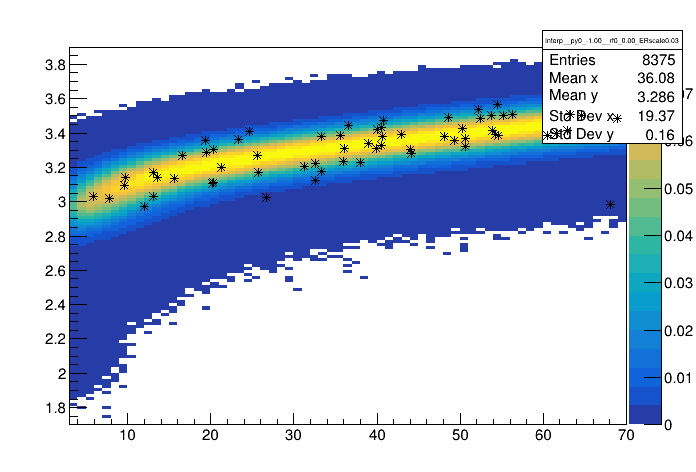

In [38]:
er_hist.Draw("colz");
data->drawS1S2("same*");
model_canvas->Draw();

Next lets look at the signal model using the public signal_model property of the likelihood
```cpp
    pdfComponent *signal = likelihood->signal_component;
```

In [39]:
pdfComponent *signal_comp = pl->signal_component;

We can then repeat the last steps to inspect the model and data.

In [40]:
TH2F signal_hist = signal_comp->getInterpolatedHisto();

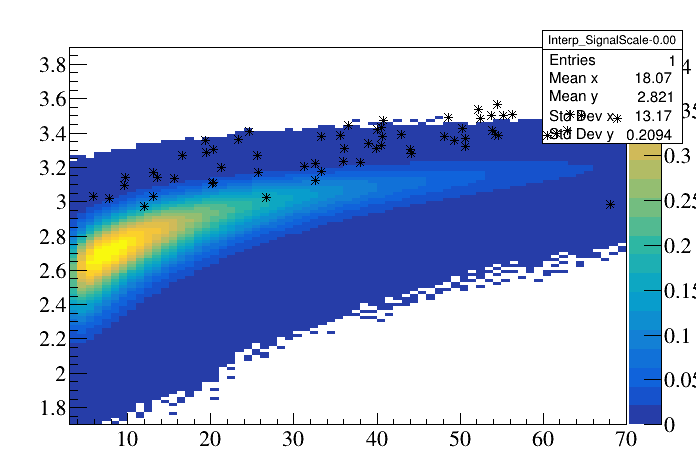

In [41]:
signal_hist.Draw("colz");
data->drawS1S2("same*");
model_canvas->Draw();

### Let's now do some more sophisticated plotting

In [42]:
TCanvas *compare_canvas = new TCanvas();

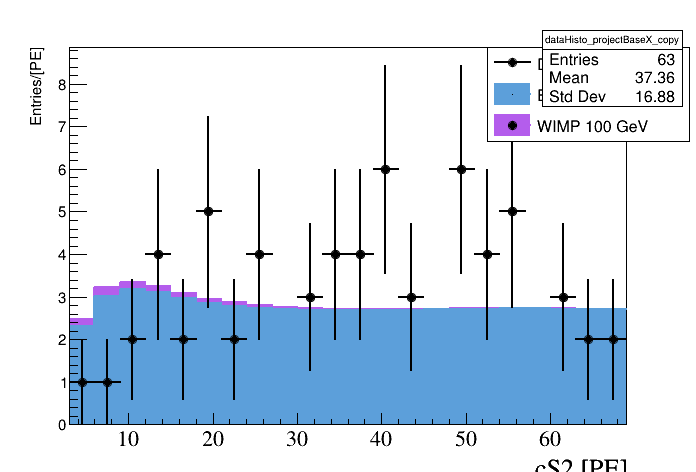

 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest      1.3                 
  1 ERscale              Free           0.029                 
  2 _py0_                Free              -1                 
  3 _rf0_                Free         0.00016                 
  4 SignalScale          Nuisance    -3.9e-06                 
Data   63
Bkg    61.7138
Signal 171.538 POI 1.28564  SignalMultiplier  0.00582961
...... That signal scaled is 1.28564


In [43]:
// class example to compare histograms in slices of S1 or S2
p = pl->getModelCompare();
//p.setNameofComponent(1,"flat");
//p.setNameofComponent(1,"AC");
p.setNameofComponent(1,"ER");
p.setNameofComponent(2,"WIMP 100 GeV");
p.rebinY = 1;        // Rebin
p.rebinX = 3;
p.doStack = true;    // put them on top of each other
p.titleY="Entries/[PE]";
p.titleX="cS2 [PE]";
p.projectionMin = 1.8;  // min in log(cs2) slice
p.projectionMax = 3.8;  // max in log(cs2) slice 
p.projectionX = true;      // Project on Xaxis the 2D histogram
//p.compareWithRatio();
p.compare();

compare_canvas->Draw();

Congradulations! You are now a Xephyrian!